# Mapping Movements: Proximity

This notebook is part of the pressure cooker for _Mapping movements: exploring the structure, vision and transformative potential of collections of movements for justice and sustainability_ of the Utrecht University Copernicus Institute, and Creative Coding Utrecht.

This notebook documents an exploration to rethink "distance" for maps of social movements, or initiatives. In the maps researched by the project, distance is often presented as geographical distance, and rendered by the placement of entries on a skewed world map (often using Mercator projection, which preserves angle, not distance). The experiment here however is interested in finding new links between entries by deploying an of-the-shelf text embedding model known as _doc2vec_. Possibly revealing new categorisations and clusters.

Many thanks to the exploration of Doc2Vec done by [Marton Trencseni](https://bytepawn.com/similar-posts-recommendation-with-doc2vec.html), on which many of these aproaches are based.

## 1. Embedding the text

In this first step, the descriptions of the initiatives are embedded using Doc2Vec. That is to say, in a series of steps the text of the descriptions is transformed  into a vector, a point in a (latent) multidimensional space: an embedding.

In [70]:
# some requirements to load for this project

import csv
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
import numpy as np

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from scipy.cluster.vq import kmeans,vq
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Then read the entries from CSV, this is an export of the spreadsheet prepred by other participants to the pressure cooker.

In [5]:
with open('initiatives.csv') as fp:
    initiatives = csv.DictReader(fp)
    print("Fields:", initiatives.fieldnames)
    initiatives = [i for i in initiatives]
print(f"{len(initiatives)} initiatives")

Fields: ['Title', 'Organisation', 'Location', 'Location - geographic', '', 'Category', 'Year', 'Website', 'Text', 'Population size']
41 initiatives


Then nltk's (a toolkit for natural language processing) "punkt" is used to parse inititatives into tokenized dict. Tokenization basically cuts the text into separate words and characters, a preparatory step before embedding.

In [8]:
# Punkt is required:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ruben/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Make `tagged_initiatives` a dict indexed by the document's ID (row in the csv), which contains a "TaggedDocument" of the initiatives' descriptions

In [10]:
tagged_initiatives = {idx : TaggedDocument(word_tokenize(f"{initiative['Title']} {initiative['Text']}"), [idx]) for idx, initiative in enumerate(initiatives)}

This is then used to create the _doc2vec_ model, using a vector_size of 20 dimensions (we only have a small set of text, thus a small dimensionality should still give plenty of variety)

In [17]:
model = Doc2Vec(tagged_initiatives.values(), vector_size=20, alpha=0.025, min_count=1, workers=16, epochs=100)

print(f"Created a Doc2Vec model with {model.corpus_count} entries, and a total of {model.corpus_total_words} words.")

Created a Doc2Vec model with 41 entries, and a total of 17278 words.


## 2. Similar initiatives

Now that we have a Doc2Vec model, we can use it to calculate some sort of similarity score between the initiative in our little dataset which is based on a mathematical similarity of words ocuring in their descriptions. 

In [22]:
def similar_initiatives(which: int, n: int = 3) -> [tuple[int, str, float]]:
    """Based on the given index, return the `n` most similar inititives.
    Returns a list of tuples: (idx, title, similarity)
    """
    if n == 'all':
        return model.dv.most_similar(positive=[model.infer_vector(tagged_initiatives[which][0])], topn=None)
    results = model.dv.most_similar(positive=[model.infer_vector(tagged_initiatives[which][0])], topn=n+1)
    results = [(idx, initiatives[idx]['Title'], score) for idx, score in results if idx != tagged_initiatives[which][1][0]]
    return results[:n]

For example, we can now find similar initiatives to the first entry of our spreadsheet:

In [26]:
idx = 0
print(f"Initiatives similar to '{initiatives[idx]['Title']}'.")
for idx, title, score in similar_initiatives(idx, 5):
    print(f"- '{title}' (#{idx}), has a similarity score of {score}")

Initiatives similar to 'Keep water in public hands!'.
- 'Observatorio del Agua de Terrassa ensures a democratic governance of water' (#24), has a similarity score of 0.62932288646698
- '‘Our Water Our Right’ campaign mobilization against water privatisation' (#16), has a similarity score of 0.5763330459594727
- 'Citizen participation and solidarity tariffs in remunicipalized water utility' (#35), has a similarity score of 0.5491517186164856
- 'Million Wells Bengaluru' (#11), has a similarity score of 0.5210488438606262
- 'Agua Para Todos tackles water privatization and the impact of climate change' (#12), has a similarity score of 0.48210036754608154


These seem to make sense, as they're all about water. But it will be hard to digest for all 41 initiatives. 

### Similarity matrix

A similarity matrix visualises all similarities in a 2D matrix. I.e. a dark red means a score of 1, that is, completely similar. A white square means total dissimilarity.

As the matrix plots entries against itself, the diagonal is 1.

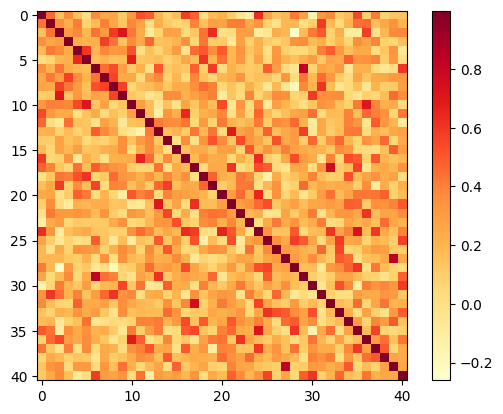

In [27]:
import matplotlib.pyplot as plt

def plot_matrix(m):
    plt.imshow(m, cmap='YlOrRd', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
similarity_matrix = [similar_initiatives(idx, n='all') for idx in tagged_initiatives]
plot_matrix(similarity_matrix)

While this plot renders all data, it is a bit hard to process. So, how can we understand these similarities, and how can we use it to find new aliances?

## 3. Find clusters

### k-means

A common aproach to clustering entries is the kmeans algorithm. This algorithm starts by picking `k` random points, and iteratively moving these as to find `k` number of distinct clusters.

In [34]:
number_of_clusters = 7

In [35]:
vectors = [model.dv[i] for i in range(41)]
centroids, _ = kmeans(vectors, number_of_clusters)

# computes cluster Id for document vectors
doc_ids,_ = vq(vectors,centroids)

clusters = defaultdict(list)
for initiative, cluster_id in zip(initiatives, doc_ids):
    clusters[cluster_id].append(initiative)

cluster_ids = sorted(list(clusters.keys()))

for cluster_id in cluster_ids:
    print('\nCluster:', cluster_id)
    for i in clusters[cluster_id]:
        print(f"- {i['Title']}")


Cluster: 0
- Keep water in public hands!
- Million Wells Bengaluru
- Agua Para Todos tackles water privatization and the impact of climate change
- ‘Our Water Our Right’ campaign mobilization against water privatisation
- Community-led response to water pollution crisis
- Observatorio del Agua de Terrassa ensures a democratic governance of water
- Eau de Paris delivers cheaper, cleaner water
- Barcelona en Comú
- Citizen's Initiative Referendum against forced demolitions of social housing
- Citizen participation and solidarity tariffs in remunicipalized water utility
- Refusing to Give Up: Civil Society’s Movement against Water Privatization in Jakarta

Cluster: 1
- Entrepatios Madrid
- Social, cultural, and economic empowerment in Bukit Duri Urban Kampung reconstruction
- Relocation of road construction project affected slum dwellers
- Integrated social reconstruction homes in Isthmus of Tehuantepec

Cluster: 2
- Women Workers Association builds tens of thousands of homes
- Disposses

While this is certainly a good first stab at clustering (i.e. the first cluster contains some water projects but also other entries and cluster 3 has projects on Palestinia & Gaza), it's major disadvantage is that one needs to specify a specific `k` number of clusters. Thus, it doesn't start from the data.

### Truncated similiarity 

Another way to find aliances would be not to directly use the embeddings to calculate clusters, but to start from the calculated similarities.

A first step in that could be to treshhold the similarity matrix and link up those that are above the given threshold. This limits the number of matches between entries. A disadvantage of this approach becomes apparent in the network graph: the clusters that emerge are very uneven. In our case most items are in a single cluster, while some entries have _no_ matches. Increasing the threshold creates even more singular items, decreasing it merges everything into one web, which pretty much beats the purpose.

In [48]:
threshold = .55

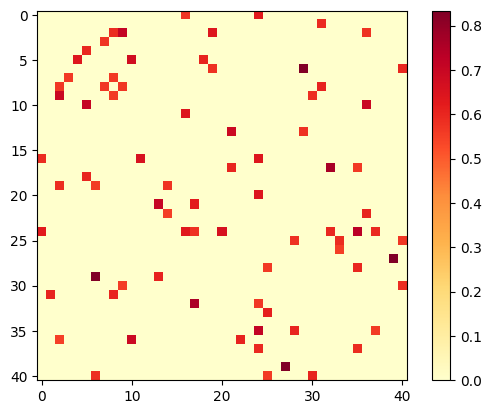

In [49]:
similarity_matrix_truncated = [[y if y > threshold else 0 for y in x] for x in similarity_matrix]
for i in range(len(similarity_matrix_truncated)):
    similarity_matrix_truncated[i][i] = 0
plot_matrix(similarity_matrix_truncated)

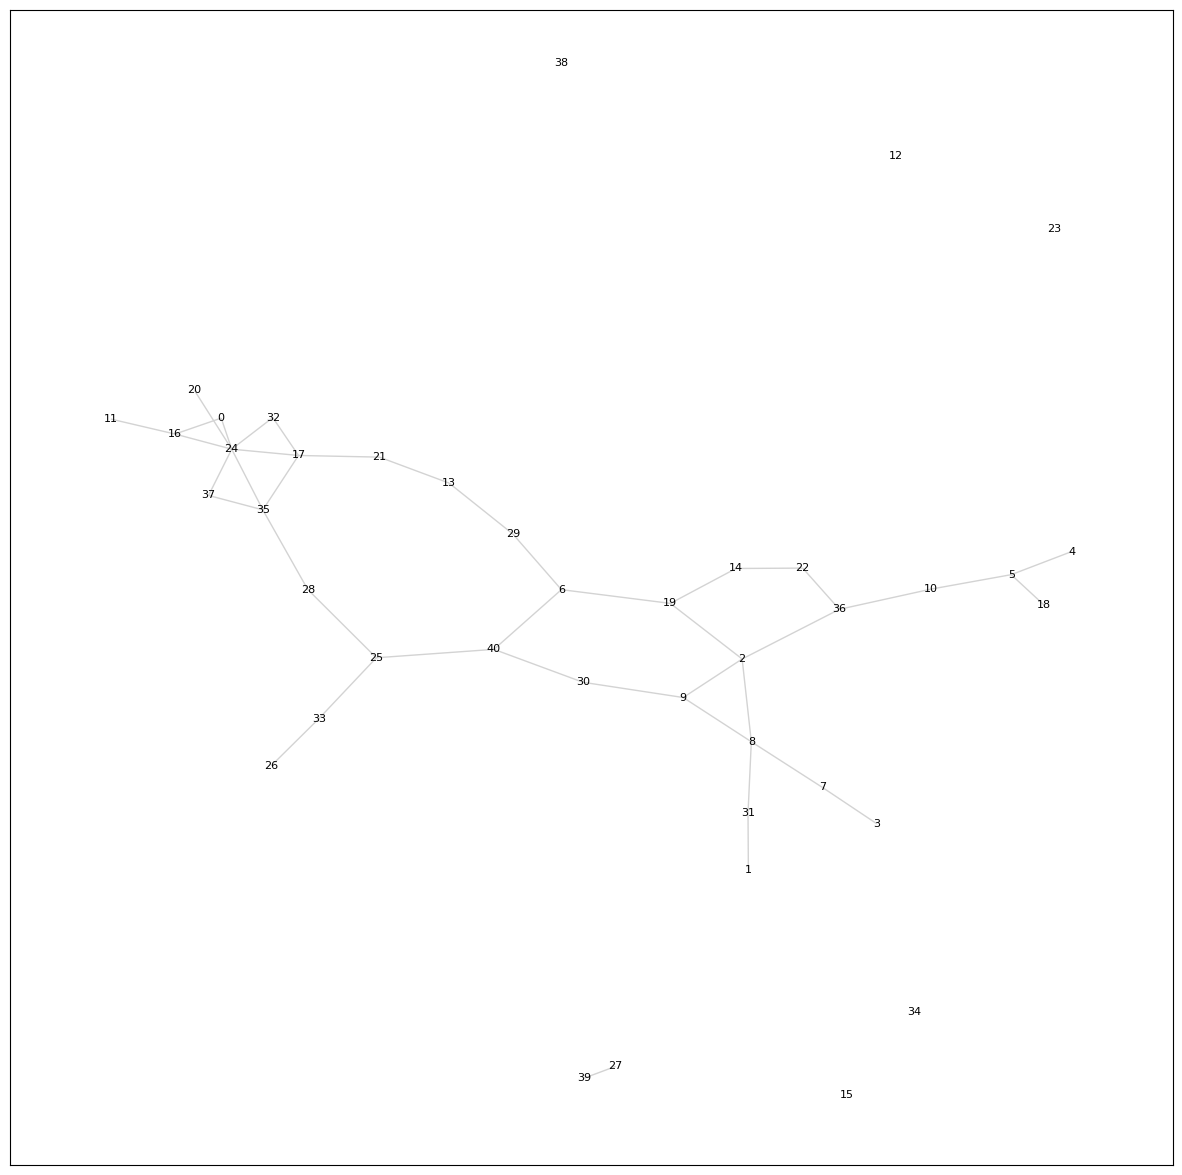

In [50]:
def plot_graph(m):
    labels = list(range(len(m)))
    df = pd.DataFrame(m, index=labels, columns=labels)
    G = nx.from_pandas_adjacency(df)
    plt.figure(figsize=(15, 15))
    nx.draw_networkx(G, nx.spring_layout(G), node_size=0, arrows=False, edge_color='lightgray', font_size=8)
    plt.show()

plot_graph(similarity_matrix_truncated)

### Similarity top-n

Another approach, suggested by Trensceni in his blog-post, is to no simply truncate the similarity matrix, but to build a web by finding the `n` most similar entries for each initiative and using these as links. Then the linked-up entries act as clusters.


In [51]:
# another approach, to avoid singletons:
# for each initiative, get the top n=3 most similar
def similarity_matrix_top_n(n=3):
    m = np.zeros((len(initiatives), len(initiatives)))
    for idx, initiative in enumerate(initiatives):
        sp = similar_initiatives(idx, n)
        idxs = [p[0] for p in sp]
        # idxs = [tagged_initiatives[p[0]][1][0] for p in sp]
        for k, j in enumerate(idxs):
            m[idx][j] = 1 #sp[k][2]
    return m


The question then is, which `n` should be used. In our case, when starting with $n=3$ all initiatives still merge into one giant cluster, the same happens with $n=2$. With $n=1$ however, clusters emerge. Some only of 2 items (each having the other as most similar entry). Yet some linking more items together.

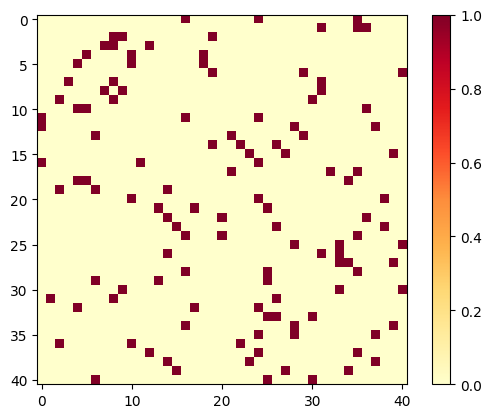

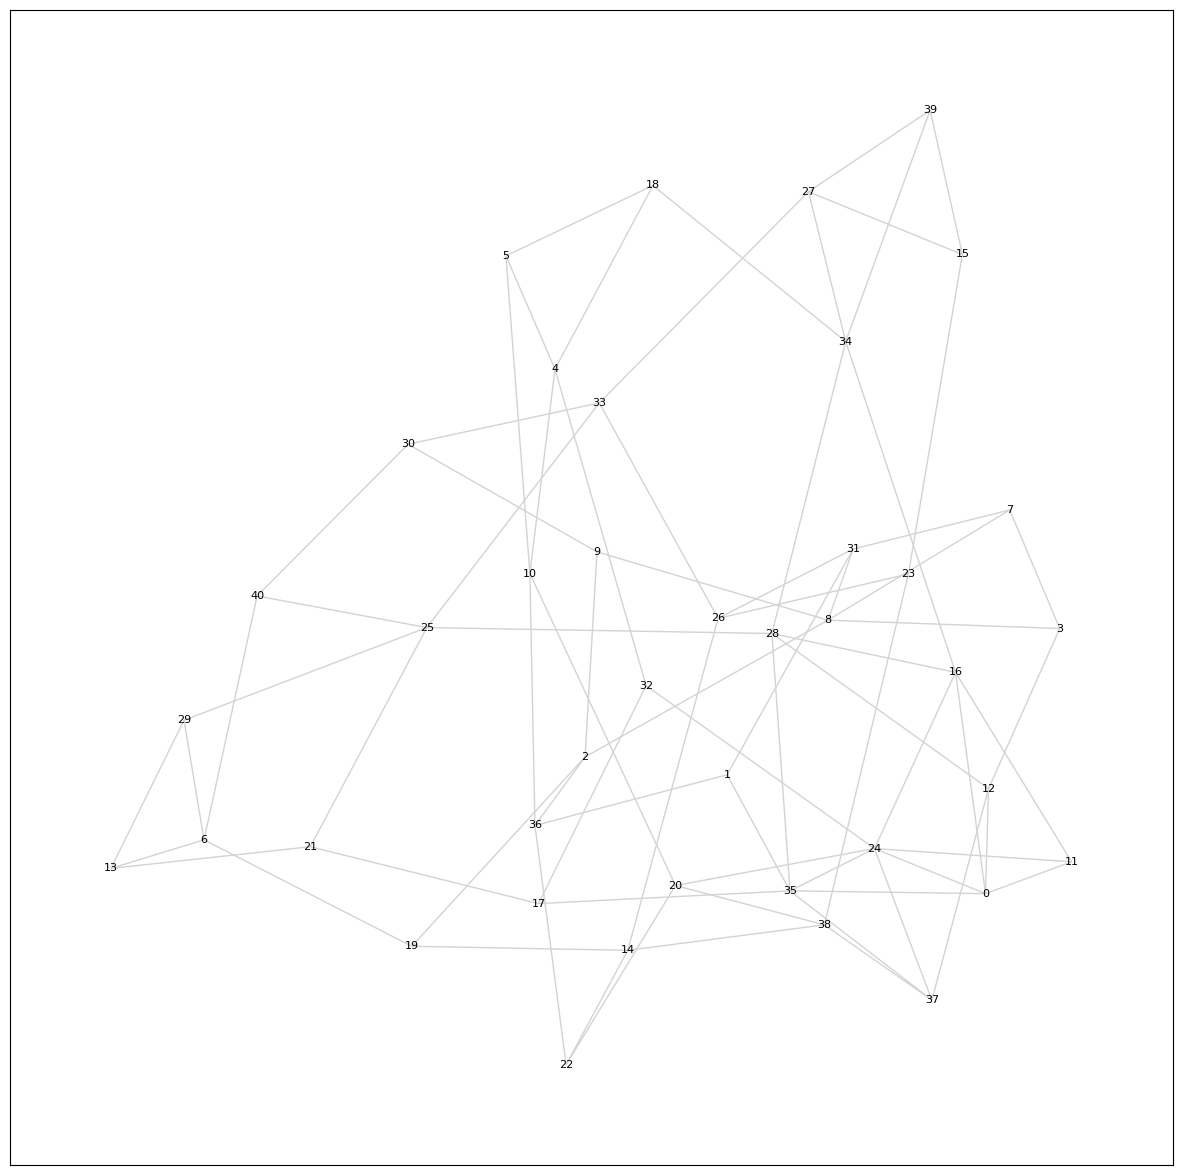

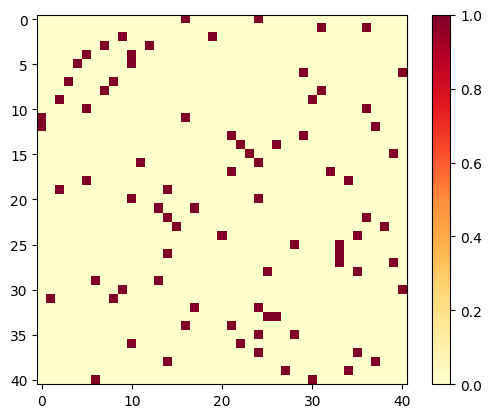

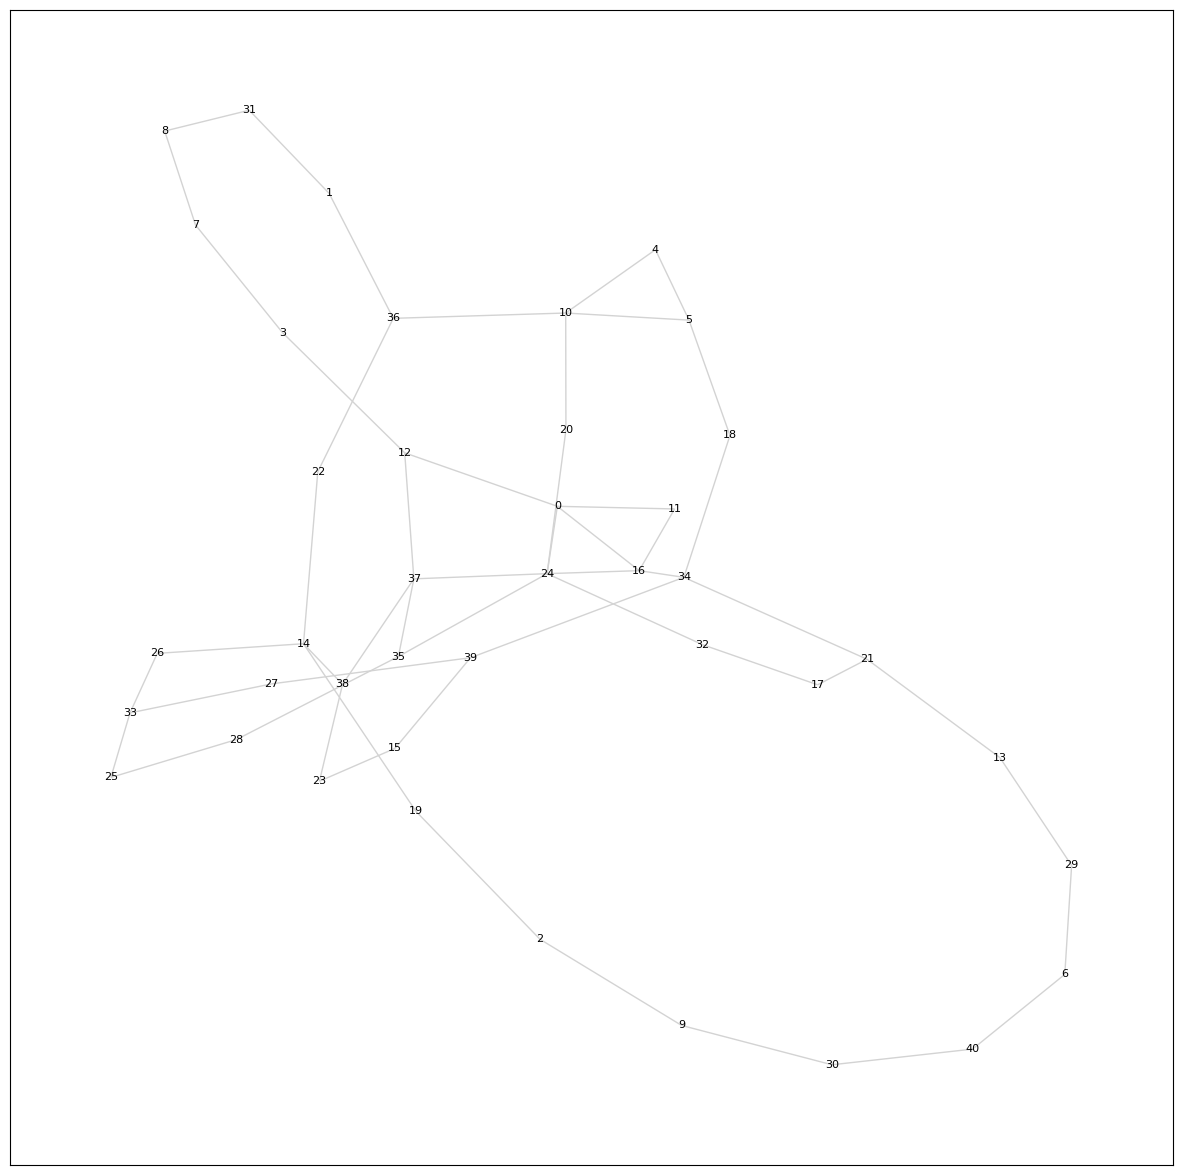

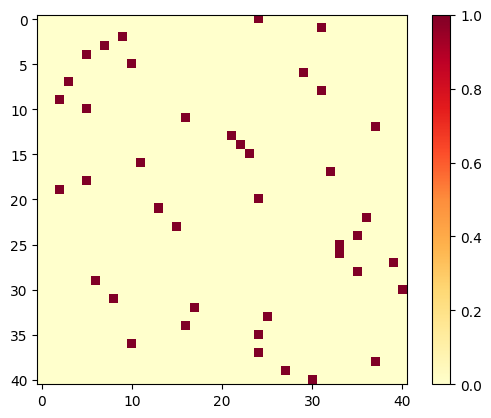

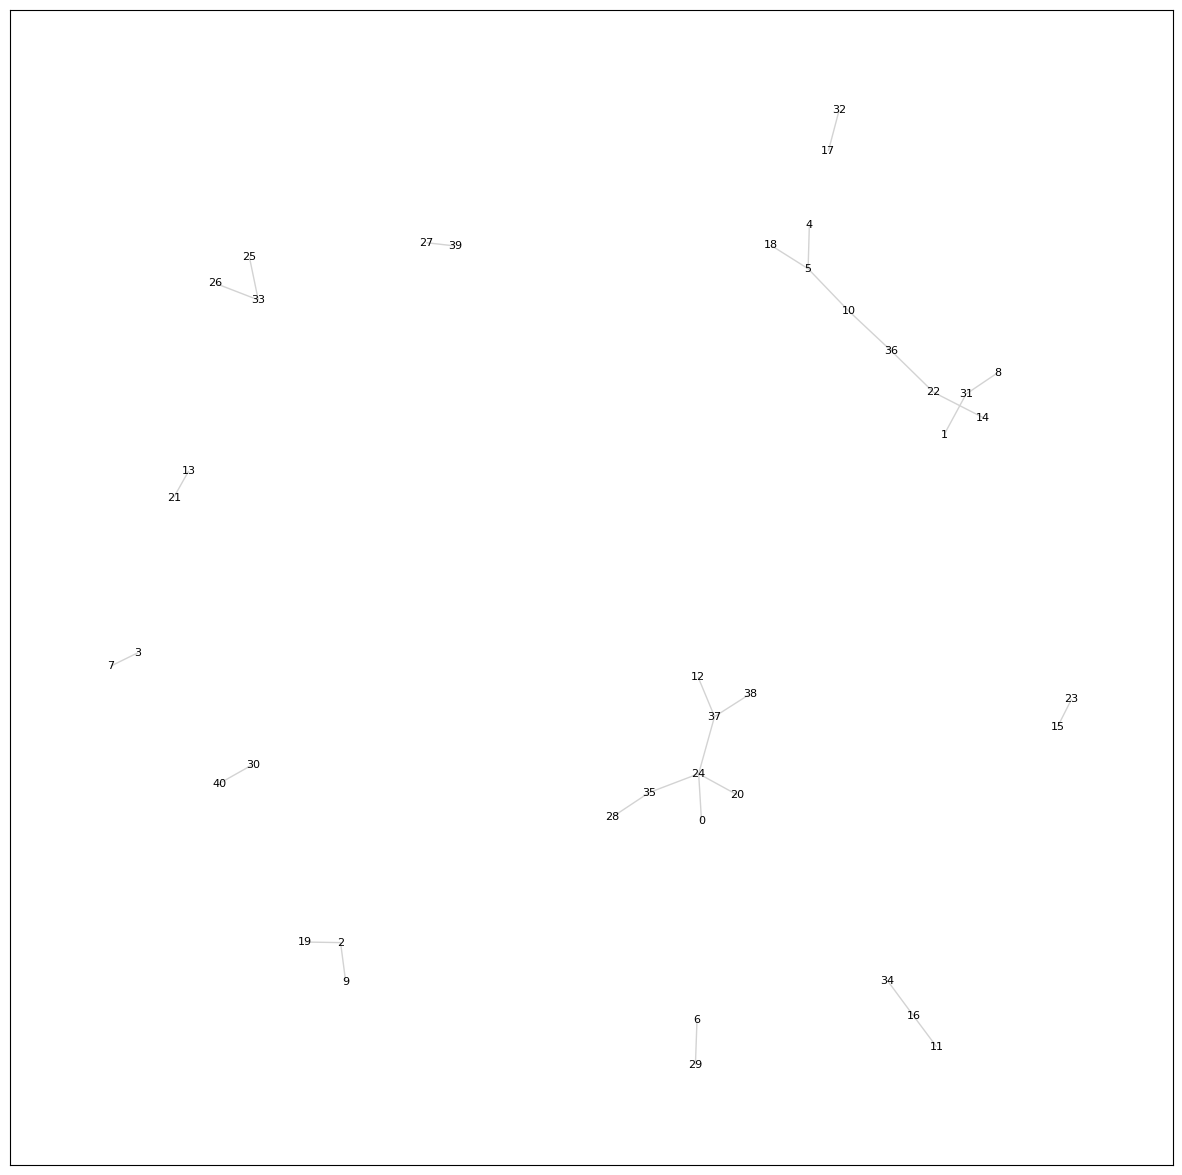

In [52]:
similarity_matrix_truncated = similarity_matrix_top_n(n=3)
plot_matrix(similarity_matrix_truncated)
plot_graph(similarity_matrix_truncated)


similarity_matrix_truncated = similarity_matrix_top_n(n=2)
plot_matrix(similarity_matrix_truncated)
plot_graph(similarity_matrix_truncated)


similarity_matrix_truncated = similarity_matrix_top_n(n=1)
plot_matrix(similarity_matrix_truncated)
plot_graph(similarity_matrix_truncated)

Instead of a linked plot, this can be rendered as a list of clusters:

In [63]:
def matrix2clusters(m):
    connected_subgraphs = set([frozenset([i]) for i in list(range(len(m)))])
    def update_subgraphs(i, j):
        join_targets = [g for g in connected_subgraphs if i in g or j in g]
        new_subgraph = frozenset({i for g in join_targets for i in g})
        for g in join_targets:
            connected_subgraphs.remove(g)
        connected_subgraphs.add(new_subgraph)
    for i in range(len(m)):
        for j in range(len(m)):
            if m[i][j] > 0:
                update_subgraphs(i, j)
    return connected_subgraphs

def print_clusters(connected_subgraphs):
    for g in connected_subgraphs:
        if len(g) == 1:
            for i in g:
                print(f'Singleton: {idx_lookup[i]}')
    for idx, g in enumerate(connected_subgraphs):
        if len(g) > 1:
            print(f'\nCluster {idx}:')
            for i in g:
                print(f"- {initiatives[i]['Title']} (#{i})")

In [64]:
similarity_clusters = matrix2clusters(similarity_matrix_truncated)
print_clusters(similarity_clusters)


Cluster 0:
- PENGON empowers Palestinian women as sustainable energy leaders (#29)
- 100% renewable energy for Gaza (#6)

Cluster 1:
- Linking urban consumers to rural producers (#9)
- Building the movement for agroecological urban gardening to ensure food sovereignty (#2)
- Waste management innovation for food security and climate change mitigation (#19)

Cluster 2:
- ‘Our Water Our Right’ campaign mobilization against water privatisation (#16)
- Citizen's Initiative Referendum against forced demolitions of social housing (#34)
- Million Wells Bengaluru (#11)

Cluster 3:
- The municipality of Burgas pioneers energy efficient housing in Bulgaria (#13)
- Energy transition built on democracy, renewables and jobs (#21)

Cluster 4:
- Women for Food Sovereignty in Cochabamba (#8)
- Valencia walks towards the future: the cycling revolution in Valencia (#1)
- Cargonomia Community Cargobike and Local Food Distribution Center (#31)

Cluster 5:
- Maison d’Éducation à l’Alimentation Durable supp

What emerges is a variety of clusters -- which capture a heterogenity of characteristics. For example, cluster 8 contains two Barcelona related initiatives, whereas the last cluster, number 12, seems to capture housing/urban related project.

In [66]:
"""Prepare a list of colors for each initiative based on their cluster. This can be used in the next step."""
colors = np.zeros(len(initiatives))
for cluster, entries in enumerate(similarity_clusters):
    for entry in entries:
        colors[entry-1] = cluster

## 4. Rendering embedding space: alternative maps of movement

It can be hard to make sense of the mathematical projections of the initiatives. The matrix rendering above is basically illegible, or at least hard to navigate. The network renderings are much more intuitive, but really only start from the calculated similarities. They are 'force' graphs, that discard any sense of the configuration of the embedding space. This becomes even more apparent when rendering it into a 2D.  

One way to do this is to reduce the 20 dimensions into only 2 using PCA. If we run a PCA on the 41 embedded initiatives and plot the first 2 dimensions, it is clear that the clusters that emerged in the previous step (as indicated with the color of the point) is really different from their placement in this kind of visualisation.

In [79]:
pca = PCA(n_components=2)

In [80]:
projected = pca.fit_transform(vectors)

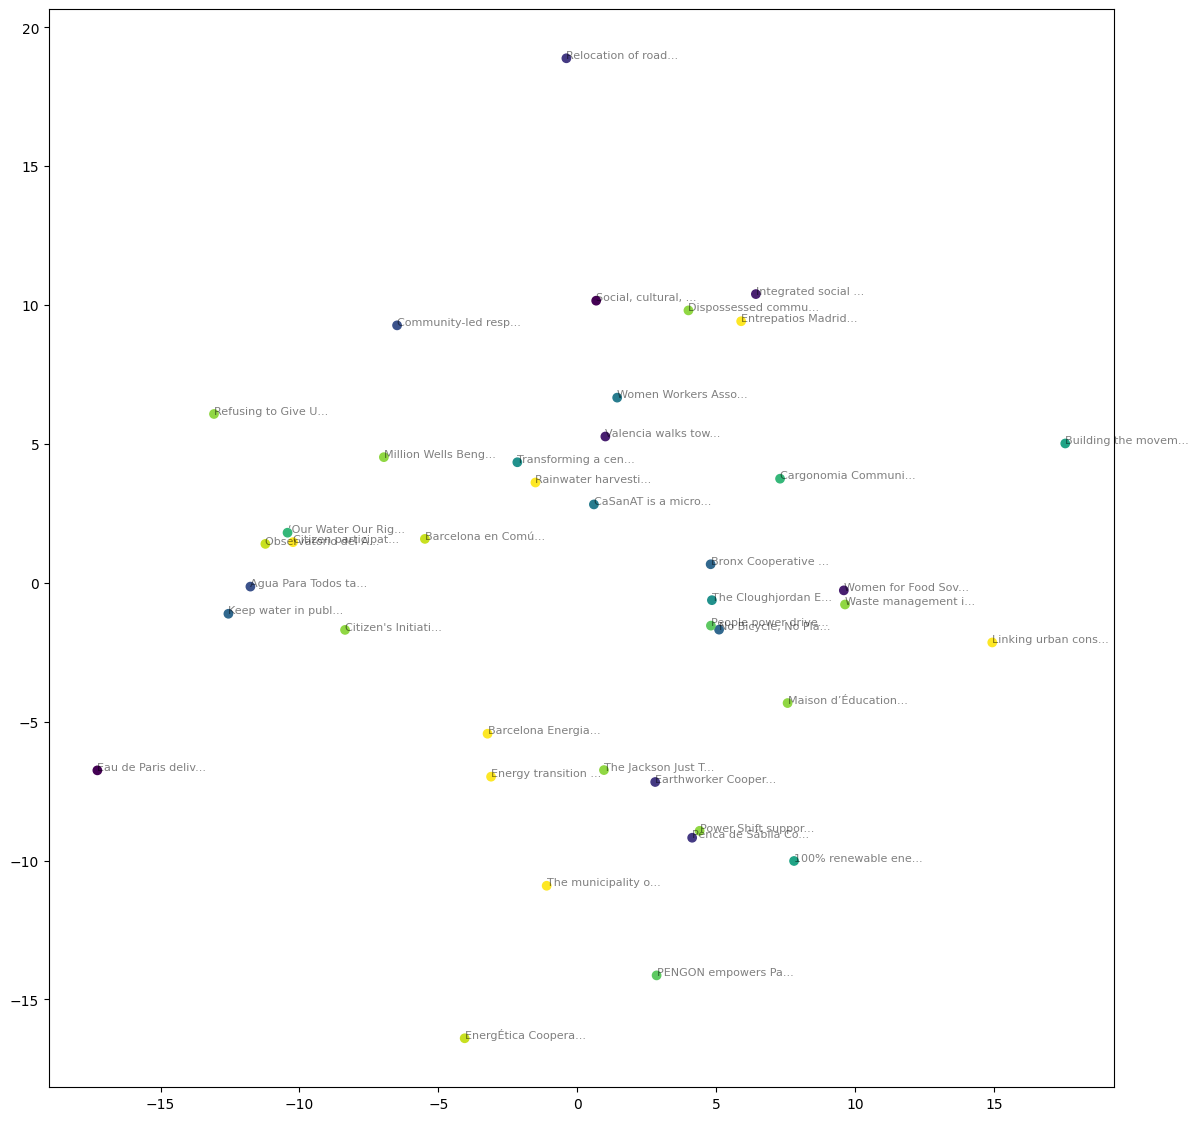

In [123]:
f = plt.figure(figsize=(14, 14))
ax = plt.subplot(aspect='equal')
ax.scatter(projected[:,0],projected[:,1], c=colors)


for idx, ini in enumerate(initiatives):
    x, y = projected[idx]
    # add label to a point
    ax.text(x, y, ini['Title'][:18]+'...', fontsize=8, alpha=.5)

Another algorithm that can be used to transform the space is t-SNE, which unlike PCA is not deterministic. I.e. it tends to produce different output on each run. This algorithm is optimised to find render similar items close together and increase the distance between less similar items; thus providing _some_ similar clusters. Loooking at the output here however, it seems not very successful at that with the small dataset used here. Nevertheless, when looking at the image below, some clusters we saw earlier reappear. For example, the top of the image contains water related projects, and some Citizen participatory initiatives appear together in the center of the mapping.

In [103]:
# Random state.
RS = 20150101
tsne_projected = TSNE(random_state=RS, perplexity=30).fit_transform(np.vstack(vectors))

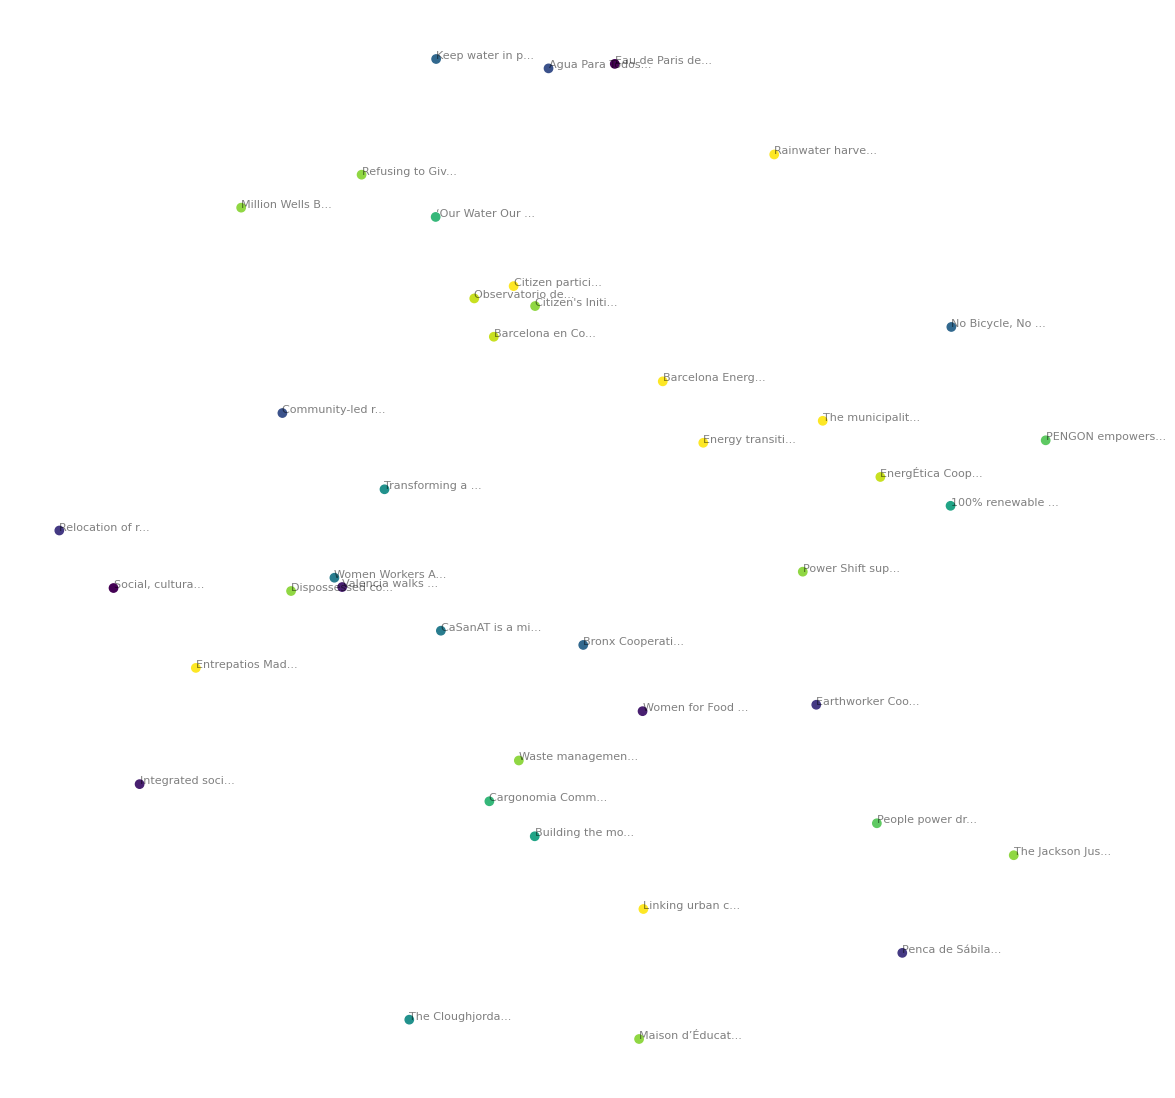

In [120]:
f = plt.figure(figsize=(14,14))
ax = plt.subplot(aspect='equal')
ax.scatter(tsne_projected[:,0], tsne_projected[:,1], c=colors)
ax.axis('off')
ax.axis('tight')

for idx, ini in enumerate(initiatives):
    x, y = tsne_projected[idx]
    # add label to a point
    ax.text(x, y, ini['Title'][:15]+'...', fontsize=8, alpha=.5)

## 5. A situated map

What if we rethink a single rendition of similarity, and instead try to consider similarity for each project, and draw a 'map' of similar projects based on that. Such a map is open for possible coalitions for each initiative.